In [1]:
import argparse
import glob
import logging
import os
import random

import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorboardX import SummaryWriter
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import WEIGHTS_NAME, BertConfig, BertForTokenClassification, BertTokenizer
import pandas as pd

import transformers
import sklearn
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

from io import open

import sys

from sklearn import metrics

import matplotlib.pyplot as plt

I0306 13:34:19.743310 140305489397504 file_utils.py:35] PyTorch version 1.0.1 available.


In [2]:
MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
}

class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["text"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
device = "cuda"
n_gpu = 1

# Set seed
set_seed(42)

In [4]:
with torch.cuda.device(n_gpu):
    print(torch.cuda.current_device())

1


In [5]:
with torch.cuda.device(n_gpu):
    # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
    pad_token_label_id = CrossEntropyLoss().ignore_index

    model_type = "bert"
    config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

    bert_type = "bert-large-uncased"
    config = config_class.from_pretrained(bert_type,
                                              num_labels=2)
    tokenizer = tokenizer_class.from_pretrained(bert_type,
                                                    do_lower_case=True)
    model = model_class.from_pretrained(bert_type, from_tf=False,
                                            config=config)
    model.to(device)

    'done'

I0306 13:34:27.927412 140305489397504 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /home/dfurman/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.fc076a4d5f1edf25ea3a2bd66e9f6f295dcd64c81dfef5b3f5a3eb2a82751ad1
I0306 13:34:27.928565 140305489397504 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 2,
  "output_attentions": false,
  "ou

In [6]:
def convert_examples_to_features(examples,
                                 label_list,
                                 max_seq_length,
                                 tokenizer,
                                 cls_token_at_end=False,
                                 cls_token="[CLS]",
                                 cls_token_segment_id=1,
                                 sep_token="[SEP]",
                                 sep_token_extra=False,
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 pad_token_label_id=-1,
                                 sequence_a_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
#         if ex_index % 10000 == 0:
#             print("Writing example {} of {}".format(ex_index, len(examples)))
#             print("E.g: {}".format(example.words))

        tokens = []
        label_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))
        

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[:(max_seq_length - special_tokens_count)]
            label_ids = label_ids[:(max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
        else:
            input_ids += ([pad_token] * padding_length)
            input_mask += ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids += ([pad_token_segment_id] * padding_length)
            label_ids += ([pad_token_label_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length
        
        if ex_index > 100 and ex_index < 120:
            print("Example {}".format(ex_index))
            print(list(zip(tokens, input_ids, label_ids)))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=label_ids))
    return features

In [7]:
def evaluate(model, test_dataloader):
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    model.eval()
    device = "cuda"
    examples = []
    with torch.cuda.device(n_gpu):
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                inputs = {"input_ids": batch[0],
                          "attention_mask": batch[1],
                          "token_type_ids": batch[2],
                          # XLM and RoBERTa don"t use segment_ids
                          "labels": batch[3]}
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]


                eval_loss += tmp_eval_loss.item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
            examples.append(tokenizer.convert_ids_to_tokens([w for b in batch[0] for w in b.detach().cpu().numpy()]))
        eval_loss = eval_loss / nb_eval_steps
        preds = np.argmax(preds, axis=2)

        return eval_loss, preds, out_label_ids, examples

In [8]:
def filtered_f1(preds, truths):
    filtered_preds = []
    filtered_labels = []
    for pred, labels in zip(preds, truths):
        for pr, lab in zip(pred, labels):
            if lab != -100:
                filtered_preds.append(pr)
                filtered_labels.append(lab)

    return metrics.f1_score(filtered_preds, filtered_labels)

In [9]:
def filtered_precision(preds, truths):
    filtered_preds = []
    filtered_labels = []
    for pred, labels in zip(preds, truths):
        for pr, lab in zip(pred, labels):
            if lab != -100:
                filtered_preds.append(pr)
                filtered_labels.append(lab)

    return metrics.precision_score(filtered_preds, filtered_labels)

In [10]:
def filtered_recall(preds, truths):
    filtered_preds = []
    filtered_labels = []
    for pred, labels in zip(preds, truths):
        for pr, lab in zip(pred, labels):
            if lab != -100:
                filtered_preds.append(pr)
                filtered_labels.append(lab)

    return metrics.recall_score(filtered_preds, filtered_labels)

In [11]:
def filtered_accuracy(preds, truths):
    filtered_preds = []
    filtered_labels = []
    for pred, labels in zip(preds, truths):
        for pr, lab in zip(pred, labels):
            if lab != -100:
                filtered_preds.append(pr)
                filtered_labels.append(lab)

    return metrics.accuracy_score(filtered_preds, filtered_labels)

In [12]:
def train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader, test_dataloader, train_batch_size=16, num_train_epochs=8, scheduler_type="linear", lr=1e-5):
    """ Train the model """
    
    train_sampler = SequentialSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)

    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8, correct_bias=False)
    if scheduler_type == "linear":
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataloader) * num_train_epochs * 0.1, num_training_steps=len(train_dataloader)*num_train_epochs)
    else:
        scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataloader) * num_train_epochs * 0.1)#, num_training_steps=t_total)
#     scheduler = WarmupLinearSchedule(optimizer, warmup_steps=120, t_total=t_total)


    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    train_loss_timeline = []
    eval_loss_timeline = []
    f1_timeline_dev = []
#     f1_timeline_train = []
    f1_timeline_test = []
    precision_timeline_test = []
    precision_timeline_dev = []
    recall_timeline_test = []
    recall_timeline_dev = []
    accuracy_timeline_test = []
    accuracy_timeline_dev = []
    model.zero_grad()
    train_iterator = trange(int(num_train_epochs), desc="Epoch", disable=False)
    w = open("{}_{}_{}_{}".format("bert_large_uncased", scheduler_type, lr, batch_size), 'w')
    set_seed(42)  # Added here for reproductibility (even between python 2 and 3)
    
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=True)
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {"input_ids": batch[0],
                        "attention_mask": batch[1],
                        "token_type_ids": batch[2],
                        # XLM and RoBERTa don"t use segment_ids
                        "labels": batch[3]
            }
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            loss.backward()
#             ipdb.set_trace()
            tr_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad()
            optimizer.zero_grad()
            
            global_step += 1

        # Evaluamos en dev
        loss, preds, truth, examples = evaluate(model, dev_dataloader)
        eval_loss_timeline.append(loss)
        train_loss_timeline.append(tr_loss / global_step)
        f1_timeline_dev.append(filtered_f1(preds, truth))
        precision_timeline_dev.append(filtered_precision(preds, truth))
        recall_timeline_dev.append(filtered_recall(preds,truth))
        accuracy_timeline_dev.append(filtered_accuracy(preds, truth))
        
        # Evaluamos en test asi cuando sabemos el mejor epoch usando dev ya tenemos el resultado de test calculado
        loss, preds, truth, examples = evaluate(model, test_dataloader)
        f1_timeline_test.append(filtered_f1(preds, truth))
        precision_timeline_test.append(filtered_precision(preds, truth))
        recall_timeline_test.append(filtered_recall(preds,truth))
        accuracy_timeline_test.append(filtered_accuracy(preds, truth))
        # Evaluamos en train para ver si siempre da igual
#         loss_tr_eval, preds_train, truth_train, examples_train = evaluate(model, train_dataloader)
#         f1_timeline_train.append(filtered_f1(preds_train, truth_train))
    tr_loss = 0
    global_step = 0
    
    min_loss = eval_loss_timeline[0]
    best_loss_epoch = 0
    for epoch, losss in enumerate(eval_loss_timeline):
        if losss < min_loss:
            best_loss_epoch = epoch
            
    max_f1 = f1_timeline_dev[0]
    best_f1_epoch = 0
    for epoch, f11 in enumerate(f1_timeline_dev):
        if f11 > max_f1:
            best_f1_epoch = epoch    

    w.write("USANDO LA LOSS:\n")
    w.write("DEV\n")
    w.write("{}\n".format(accuracy_timeline_dev[best_loss_epoch]))
    w.write("{}\n".format(precision_timeline_dev[best_loss_epoch]))
    w.write("{}\n".format(recall_timeline_dev[best_loss_epoch]))
    w.write("{}\n".format(f1_timeline_dev[best_loss_epoch]))
    w.write("\n")
    w.write("TEST\n")
    w.write("{}\n".format(accuracy_timeline_test[best_loss_epoch]))
    w.write("{}\n".format(precision_timeline_test[best_loss_epoch]))
    w.write("{}\n".format(recall_timeline_test[best_loss_epoch]))
    w.write("{}\n".format(f1_timeline_test[best_loss_epoch]))
    
    w.write("USANDO F1:\n")
    w.write("DEV\n")
    w.write("{}\n".format(accuracy_timeline_dev[best_f1_epoch]))
    w.write("{}\n".format(precision_timeline_dev[best_f1_epoch]))
    w.write("{}\n".format(recall_timeline_dev[best_f1_epoch]))
    w.write("{}\n".format(f1_timeline_dev[best_f1_epoch]))
    w.write("\n")
    w.write("TEST\n")
    w.write("{}\n".format(accuracy_timeline_test[best_f1_epoch]))
    w.write("{}\n".format(precision_timeline_test[best_f1_epoch]))
    w.write("{}\n".format(recall_timeline_test[best_f1_epoch]))
    w.write("{}\n".format(f1_timeline_test[best_f1_epoch]))
    
    w.close()
    
    return global_step, train_loss_timeline, eval_loss_timeline, f1_timeline_dev

In [13]:
data = pd.read_csv("../train_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")

getter = SentenceGetter(data)
#Sacarle las oraciones que empiezan con "<", el autor, abstract, etc

sentences = [[s[0] for s in sent] for sent in getter.sentences]
labels = [[s[1] for s in sent] for sent in getter.sentences]

num_labels = len(labels)

examples = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences, labels))]
print(examples[22].words)
print(examples[22].labels)

['Motion', 'is', 'one', 'of', 'the', 'most', 'important', 'ingredients', 'of', 'CG', 'movies', 'and', 'computer', 'games', '.']
['claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'O']


In [14]:
with torch.cuda.device(n_gpu):
    possible_labels = ["O", "claim"]
    features = convert_examples_to_features(examples, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )


        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)

    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    train_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

Example 101
[('[CLS]', 101, -100), ('each', 2169, 0), ('frame', 4853, 0), ('would', 2052, 0), ('be', 2022, 0), ('a', 1037, 0), ('node', 13045, 0), ('.', 1012, 0), ('[SEP]', 102, -100)]
Example 102
[('[CLS]', 101, -100), ('there', 2045, 0), ('would', 2052, 0), ('be', 2022, 0), ('an', 2019, 0), ('edge', 3341, 0), ('from', 2013, 0), ('every', 2296, 0), ('frame', 4853, 0), ('to', 2000, 0), ('every', 2296, 0), ('frame', 4853, 0), ('that', 2008, 0), ('could', 2071, 0), ('follow', 3582, 0), ('it', 2009, 0), ('in', 1999, 0), ('an', 2019, 0), ('acceptable', 11701, 0), ('sp', 11867, 0), ('##lice', 13231, -100), ('.', 1012, 0), ('[SEP]', 102, -100)]
Example 103
[('[CLS]', 101, -100), ('in', 1999, 0), ('this', 2023, 0), ('graph', 10629, 0), (',', 1010, 0), ('there', 2045, 0), ('would', 2052, 0), ('be', 2022, 0), ('(', 1006, 0), ('at', 2012, 0), ('least', 2560, 0), (')', 1007, 0), ('an', 2019, 0), ('edge', 3341, 0), ('from', 2013, 0), ('the', 1996, 0), ('k', 1047, 0), ('a', 1037, 0), ('th', 16215, 

In [15]:
devdata = pd.read_csv("../dev_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")

getter = SentenceGetter(devdata)

sentences_dev = [[s[0] for s in sent] for sent in getter.sentences]
labels_dev = [[s[1] for s in sent] for sent in getter.sentences]

num_labels = len(labels_dev)

examples_dev = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences_dev, labels_dev))]

len(examples_dev)

2572

In [16]:
with torch.cuda.device(n_gpu):
    device = "cuda"
    possible_labels = ["O", "claim"]
    features_dev = convert_examples_to_features(examples_dev, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )

        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features_dev], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features_dev], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features_dev], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features_dev], dtype=torch.long)
    
    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    dev_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    dev_sampler = SequentialSampler(dev_dataset)
    dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=1)

Example 101
[('[CLS]', 101, -100), ('2009', 2268, 0), (']', 1033, 0), ('.', 1012, 0), ('[SEP]', 102, -100)]
Example 102
[('[CLS]', 101, -100), ('has', 2038, 0), ('##e', 2063, -100), ('et', 3802, 0), ('al', 2632, 0), ('.', 1012, 0), ('[SEP]', 102, -100)]
Example 103
[('[CLS]', 101, -100), ('[', 1031, 0), ('2003', 2494, 0), (']', 1033, 0), ('[SEP]', 102, -100)]
Example 104
[('[CLS]', 101, -100), ('opt', 23569, 1), ('##imi', 27605, -100), ('##ze', 4371, -100), ('a', 1037, 1), ('cp', 18133, 1), ('##g', 2290, -100), ('-', 1011, -100), ('based', 2241, -100), ('(', 1006, 0), ('central', 2430, 0), ('pattern', 5418, 0), ('generator', 13103, 0), (')', 1007, 0), ('loco', 28046, 1), ('##mot', 18938, -100), ('##ion', 3258, -100), ('controller', 11486, 1), ('[', 1031, 0), ('tag', 6415, 0), ('##a', 2050, -100), ('1995', 2786, 0), (']', 1033, 0), ('for', 2005, 1), ('3d', 7605, 1), ('mu', 14163, 1), ('##scu', 28817, -100), ('##los', 10483, -100), ('##kel', 11705, -100), ('##eta', 12928, -100), ('##l', 

In [17]:
testdata = pd.read_csv("../test_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")

getter = SentenceGetter(testdata)

sentences_test = [[s[0] for s in sent] for sent in getter.sentences]
labels_test = [[s[1] for s in sent] for sent in getter.sentences]

num_labels = len(labels_test)

examples_test = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences_test, labels_test))]

len(examples_test)

2944

In [18]:
with torch.cuda.device(n_gpu):
    device = "cuda"
    possible_labels = ["O", "claim"]
    features_test = convert_examples_to_features(examples_test, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )

        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features_test], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features_test], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features_test], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features_test], dtype=torch.long)
    
    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    test_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=1)

Example 101
[('[CLS]', 101, -100), ('using', 2478, 0), ('this', 2023, 0), ('vo', 29536, 0), ('##rno', 19139, -100), ('##i', 2072, -100), ('-', 1011, -100), ('based', 2241, -100), ('approach', 3921, 0), ('for', 2005, 0), ('te', 8915, 0), ('##tra', 6494, -100), ('##hedral', 27310, -100), ('mesh', 20437, 0), ('##es', 2229, -100), ('would', 2052, 0), ('yield', 10750, 0), ('a', 1037, 0), ('pressure', 3778, 0), ('matrix', 8185, 0), ('similar', 2714, 0), ('to', 2000, 0), ('ours', 14635, 0), ('.', 1012, 0), ('[SEP]', 102, -100)]
Example 102
[('[CLS]', 101, -100), ('like', 2066, 0), ('our', 2256, 0), ('method', 4118, 0), (',', 1010, 0), ('[SEP]', 102, -100)]
Example 103
[('[CLS]', 101, -100), ('bro', 22953, 0), ('##chu', 20760, -100), ('et', 3802, 0), ('al', 2632, 0), ('.', 1012, 0), ('[SEP]', 102, -100)]
Example 104
[('[CLS]', 101, -100), ('[', 1031, 0), ('2010', 2230, 0), (']', 1033, 0), ('[SEP]', 102, -100)]
Example 105
[('[CLS]', 101, -100), ('used', 2109, 1), ('this', 2023, 1), ('disc', 58

In [19]:
with torch.cuda.device(n_gpu):
    for sched in ["linear","constant"]:
        for lr in [1e-5, 2e-5, 5e-6]:
            for batch_size in [24]:
                model = model_class.from_pretrained(bert_type, from_tf=False, config=config)
                model.to(device)
                global_step, train_loss_timeline, dev_loss_timeline, f1_timeline = train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader, test_dataloader, scheduler_type=sched, lr=lr, train_batch_size=batch_size)
                if not os.path.exists("../pretrained-models/bert-large-uncased-8epochs-{}_{}_{}".format(sched, str(lr), str(batch_size))):
                    os.mkdir("../pretrained-models/bert-large-uncased-8epochs-{}_{}_{}".format(sched, str(lr), str(batch_size)))
                model.save_pretrained("../pretrained-models/bert-large-uncased-8epochs-{}_{}_{}".format(sched, str(lr), str(batch_size)))

I0306 13:36:13.823281 140305489397504 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0306 13:36:24.125788 140305489397504 modeling_utils.py:480] Weights of BertForTokenClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0306 13:36:24.126874 140305489397504 modeling_utils.py:483] Weights from pretrained model not used in BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 8/8 [54:42<00:00, 41

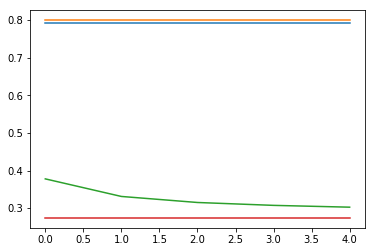

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(f1_timeline)), f1_timeline, label="f1")
ax.plot(np.arange(len(f1_timeline_train)), f1_timeline_train, label="f1")
ax.plot(np.arange(len(train_loss_timeline)), train_loss_timeline, label="train")
ax.plot(np.arange(len(dev_loss_timeline)), dev_loss_timeline, label="dev")

In [20]:
f1_timeline_train

[0.7997313429602105,
 0.7997313429602105,
 0.7997313429602105,
 0.7997313429602105,
 0.7997313429602105]

In [21]:
with torch.cuda.device(n_gpu):
    model = model_class.from_pretrained(bert_type, from_tf=False, config=config)
    model.to(device)
    global_step, train_loss_timeline, dev_loss_timeline, f1_timeline, f1_timeline_train = train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader, 5, 5, "linear", len(dev_dataloader)*2)
    model.save_pretrained("../pretrained-models/bert-large-uncased-5epochs-1e-5_linear_schedule_x2")

I0218 09:07:57.898455 140025004766976 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0218 09:08:08.360332 140025004766976 modeling_utils.py:480] Weights of BertForTokenClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0218 09:08:08.361425 140025004766976 modeling_utils.py:483] Weights from pretrained model not used in BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 5/5 [1:09:32<00:00, 

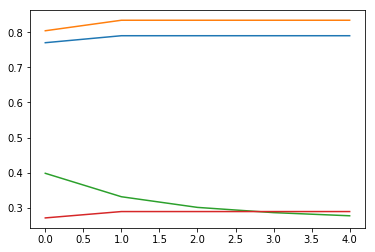

In [22]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(f1_timeline)), f1_timeline, label="f1")
ax.plot(np.arange(len(f1_timeline_train)), f1_timeline_train, label="f1")
ax.plot(np.arange(len(train_loss_timeline)), train_loss_timeline, label="train")
ax.plot(np.arange(len(dev_loss_timeline)), dev_loss_timeline, label="dev")

In [23]:
f1_timeline

[0.7700408163265307,
 0.7899424184261036,
 0.7899424184261036,
 0.7899424184261036,
 0.7899424184261036]

In [24]:
with torch.cuda.device(n_gpu):
    model = model_class.from_pretrained(bert_type, from_tf=False, config=config)
    model.to(device)
    global_step, train_loss_timeline, dev_loss_timeline, f1_timeline, f1_timeline_train = train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader, 5, 5, "linear", len(dev_dataloader)*4)
    model.save_pretrained("../pretrained-models/bert-large-uncased-5epochs-1e-5_linear_schedule_x4")

I0218 14:31:14.359904 140025004766976 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
Epoch: 100%|██████████| 5/5 [1:09:18<00:00, 831.49s/it]
I0218 15:40:43.891940 140025004766976 configuration_utils.py:87] Configuration saved in ../pretrained-models/bert-large-uncased-5epochs-1e-5_linear_schedule_x4/config.json
I0218 15:40:44.707392 140025004766976 modeling_utils.py:258] Model weights saved in ../pretrained-models/bert-large-uncased-5epochs-1e-5_linear_schedule_x4/pytorch_model.bin


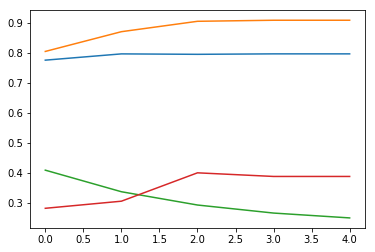

In [25]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(f1_timeline)), f1_timeline, label="f1")
ax.plot(np.arange(len(f1_timeline_train)), f1_timeline_train, label="f1")
ax.plot(np.arange(len(train_loss_timeline)), train_loss_timeline, label="train")
ax.plot(np.arange(len(dev_loss_timeline)), dev_loss_timeline, label="dev")

In [27]:
f1_timeline_train

[0.804206760424377,
 0.8699473071031917,
 0.904564167453797,
 0.9080720401535283,
 0.9080720401535283]

16611

In [31]:
with torch.cuda.device(n_gpu):
    model = model_class.from_pretrained(bert_type, from_tf=False, config=config)
    model.to(device)
    global_step, train_loss_timeline, dev_loss_timeline, f1_timeline, f1_timeline_train = train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader, num_train_epochs=2, scheduler_type="constant")
model.save_pretrained("../pretrained-models/bert-large-uncased-2epochs-1e-5_constant_schedule_proportional")

I0221 21:17:09.499602 139700597274368 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0221 21:17:19.540846 139700597274368 modeling_utils.py:480] Weights of BertForTokenClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0221 21:17:19.541937 139700597274368 modeling_utils.py:483] Weights from pretrained model not used in BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 2/2 [16:23<00:00, 49

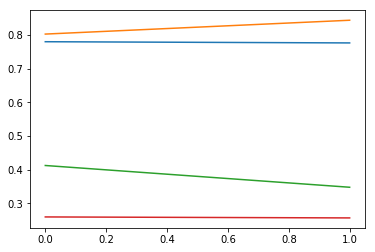

In [32]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(f1_timeline)), f1_timeline, label="f1")
ax.plot(np.arange(len(f1_timeline_train)), f1_timeline_train, label="f1")
ax.plot(np.arange(len(train_loss_timeline)), train_loss_timeline, label="train")
ax.plot(np.arange(len(dev_loss_timeline)), dev_loss_timeline, label="dev")

In [33]:
f1_timeline

[0.7794123151787387, 0.7758564702062023]

In [26]:
model = BertForTokenClassification.from_pretrained("../pretrained-models/bert-large-uncased-2epochs-1e-5_constant_schedule_proportional")
with torch.cuda.device(1):
    model.to("cuda")
    eval_loss, preds, out_label_ids, examples = evaluate(model, test_dataloader)

I0226 00:28:52.636839 139756314355456 configuration_utils.py:182] loading configuration file ../pretrained-models/bert-large-uncased-2epochs-1e-5_constant_schedule_proportional/config.json
I0226 00:28:52.638084 139756314355456 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}



In [20]:
len(examples)

2572

In [29]:
filtered_preds = []
filtered_labels = []
for pred, labels in zip(preds, out_label_ids):
    for pr, lab in zip(pred, labels):
        if lab != -100:
            filtered_preds.append(pr)
            filtered_labels.append(lab)

In [30]:
filtered_preds

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,


In [30]:
filtered_f1(preds, out_label_ids)

0.7147352496217851

I0210 15:16:27.283423 140657494583040 configuration_utils.py:87] Configuration saved in ../pretrained-models/bert-large-uncased-5epochs-1e-5/config.json
I0210 15:16:28.130554 140657494583040 modeling_utils.py:258] Model weights saved in ../pretrained-models/bert-large-uncased-5epochs-1e-5/pytorch_model.bin
